## Load an LTSF-Linear Model

Train the model through 'electricity.sh' bash script.
Load an .pth file from the checkpoints folder.

Model(
  (Linear): Linear(in_features=96, out_features=24, bias=True)
) with 2328 parameters


tensor([[[3875.6628],
         [3245.1758],
         [3136.1948],
         [2937.8779],
         [2875.9290],
         [3084.7505],
         [2881.7751],
         [2651.0662],
         [2982.2390],
         [3588.5708],
         [4152.4414],
         [4879.3418],
         [5366.0386],
         [5080.6201],
         [4719.8203],
         [4390.3188],
         [4449.3169],
         [4709.2607],
         [5411.9233],
         [5872.2695],
         [5763.9014],
         [5477.1299],
         [5102.1934],
         [4576.6836]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.11/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


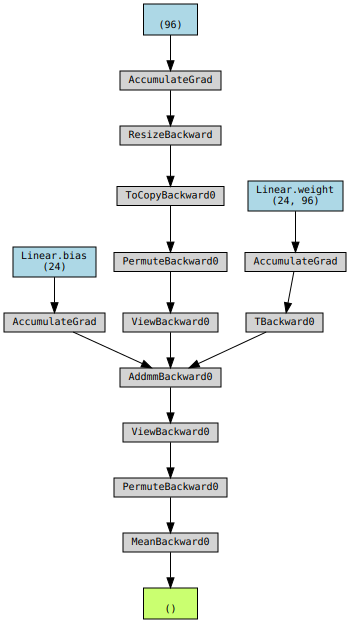

In [17]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear


class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'Linear'
target = '40'
seq_len = 96
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)

basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)

state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)

print(circuit, 'with {} parameters'.format(total_params))

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
# make_dot(y.mean(), params=dict(circuit.named_parameters()), show_attrs=True, show_saved=True)
make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img = make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img.render(model, format="png")

## ZK Inference

#### Define Files Path

In [18]:
import os, json, ezkl
from timeit import default_timer as timer

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')
proof_path = os.path.join('test.pf')
sol_code_path = os.path.join('verify.sol')
abi_path = os.path.join('verify.abi')

#### Convert Model to ONNX

In [19]:
# Model was trained by 'electricity.sh' and stored into the checkpoint state 'checkpoint.pth'.
# Now we need to export the onnx file from this state file with model inputs.

# Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

# Serialize data into file:
json.dump( data, open(data_path, 'w' ))

input_size = os.stat(data_path).st_size / 1024
onnx_size = os.stat(model_path).st_size / 1024
print("Input.json size: {}KB".format(input_size))
print("network.onnx size: {}KB".format(onnx_size))

Input.json size: 0.767578125KB
network.onnx size: 9.5595703125KB


### Set Circuit Parameters

In [20]:
model_path = os.path.join('network.onnx')
settings_path = os.path.join('settings.json')
data_path = os.path.join('input.json')

py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "private"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

# run_args.variables = [("batch_size", 1)]
# run_args.logrows = 20

res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
assert res == True

res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True



 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+-------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error  | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -0.30433145 | 3.5317383    | 3.5317383 | -2.9389648 | 1.1039734      | 3.5317383        | 3.5317383     | 0.07714844    | 2.010033           | -0.00010244648     | 0.00027499985          |
+-------------+--------------+-----------+------------+----------------+------------------+---------------+------

In [21]:
try:
    table_string = ezkl.table(model_path, py_run_args)
    print(table_string)
except Exception as e:
    print(f"An error occurred: {e}")

 
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────┬──────────────────┬────────────┐
│ idx │ opkind                                                                                              │ out_scale │ inputs           │ out_dims   │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼────────────┤
│ 0   │ Input                                                                                               │ 7         │                  │ [1, 96, 1] │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼────────────┤
│ 1   │ CONST (scale=7)                                                                                     │ 7         │                  │ [96, 24]   │
├─────┼───────────────────────────────────────────────────────────────────

### Compile the Model

In [22]:
start = timer()

res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

end = timer()
print("Compilation time used: {} seconds.".format(end - start))

Compilation time used: 0.005545496002014261 seconds.


### Creating the Circuit

In [23]:
# get public srs from kzg ceremony, saved to srs path. 
res = ezkl.get_srs(srs_path=srs_path, settings_path=settings_path)

In [24]:
start = timer()

# setup the circuit and make sure the keys are generated afterwards. 
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)

end = timer()
print("time used: {} seconds.".format(end - start))

time used: 0.5512757989999955 seconds.


### Generate a Proof

In [25]:
# Prove, invoked with ezkl prove at the cli or ezkl.prove() in Python, is called by the prover, often on the client.
import tracemalloc
import numpy as np

tracemalloc.start()
current_memories = []
peak_memories = []
prove_times = []
for i in range(10): 
    start = timer()
    res = ezkl.gen_witness(
            data_path, 
            compiled_model_path, 
            witness_path
          )
    assert os.path.isfile(witness_path)

    # GENERATE A PROOF

    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "single",
            srs_path,
        )
    assert os.path.isfile(proof_path)
    end = timer()
    prove_time = end - start

    current, peak = tracemalloc.get_traced_memory()
    current_memories.append(current/(1024*1024))
    peak_memories.append(peak/(1024*1024))
    prove_times.append(prove_time)
    tracemalloc.reset_peak()
    # tracemalloc.clear_traces()
    del current, peak, start, end
print('Average current memory [MB]: {}, average peak memory [MB]: {} +/- {}'.format(
      round(np.mean(current_memories), 4), round(np.mean(peak_memories), 4), 
      round(np.std(peak_memories), 4))
)

Average current memory [MB]: 66.7516, average peak memory [MB]: 73.2288 +/- 19.3885


### Verify

#### VERIFY off-chain

In [26]:
start = timer()
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")
end = timer()
print("time used: {} seconds".format(end - start))

verified
time used: 0.01260763300160761 seconds


#### VERIFY on-chain

In [27]:
# Create verifier contract
res = ezkl.create_evm_verifier(
        srs_path=srs_path, 
        vk_path=vk_path,
        sol_code_path=sol_code_path,
        settings_path=settings_path
    )
verifier_size = os.stat(sol_code_path).st_size / 1024
print("{} size: {}KB".format(sol_code_path, verifier_size))

verify.sol size: 60.0341796875KB


In [28]:
# 1. install anvil if you haven't already
# cargo install --git https://github.com/foundry-rs/foundry --profile local --locked anvil
# 2. spin up a local EVM through anvil in a separate terminal 
# anvil -p 3030

# Deploy the verifier contract onchain
sol_code_path = os.path.join("verify.sol")
address_path = os.path.join('contractAddr.txt')

res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

In [29]:
# # Verify proof onchain
# try:
#   with open(address_path, 'r') as f:
#     addr = f.readline()

#   res = ezkl.verify_evm(
#       proof_path,
#       addr,
#       'http://127.0.0.1:3030'
#   )

#   assert res == True
# except Exception as e:
#     print(f"An error occurred: {e}")
#     pass

## Stats

In [30]:
from subprocess import Popen, PIPE

input_size = round(os.stat(data_path).st_size / 1024, 3)
onnx_size = round(os.stat(model_path).st_size / 1024, 3)
print("{} size: {}KB".format(data_path, input_size))
print("{} size: {}KB".format(model_path, onnx_size))
proof_size = round(os.stat(proof_path).st_size / 1024, 3)
print("{} size: {}KB".format(proof_path, proof_size))
prove_time = round(np.mean(prove_times), 3)
print("prove time used: {} seconds".format(prove_time))
prove_mem = round(np.mean(peak_memories), 3)
print("prove memory used: {} MB".format(prove_mem))

verifier_size = round(os.stat(sol_code_path).st_size / 1024, 3)
print("{} size: {}KB".format(sol_code_path, verifier_size))

p = Popen(["solc", "--bin", "--optimize", "verify.sol"], stdin=PIPE, stdout=PIPE, stderr=PIPE)
output, err = p.communicate(b"input data that is passed to subprocess' stdin")
verifier_code_size = round(sys.getsizeof((output.split(b'\n')[3])) / 1000, 3)
print("Verifier bytecode size: {}KB".format(verifier_code_size))

input.json size: 0.768KB
network.onnx size: 9.56KB
test.pf size: 15.336KB
prove time used: 0.62 seconds
prove memory used: 73.229 MB
verify.sol size: 60.034KB
Verifier bytecode size: 14.729KB


In [31]:
colums = ['Parameters', 'Input Size', 'ONNX Size', 'Proof Size',
          'Prove Time', 'Prove Mem', 'Verifier Size', 'Bytecode Size']
stats = [[total_params], [input_size], [onnx_size], [proof_size],
        [prove_time], [prove_mem], [verifier_size], [verifier_code_size]]
data = dict(zip(colums, stats))
index = [seq_len]
df = pd.DataFrame(data=data, index=index)
output_path='zkml_perf.csv'
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
df

,Parameters,Input Size,ONNX Size,Proof Size,Prove Time,Prove Mem,Verifier Size,Bytecode Size
96,2328,0.768,9.56,15.336,0.62,73.229,60.034,14.729


In [16]:
# import tracemalloc
# import numpy as np

# tracemalloc.start()
# current_memories = []
# peak_memories = []
# for i in range(10): 
#     a = list(range(100000))
#     current, peak = tracemalloc.get_traced_memory()
#     current_memories.append(current/(1024*1024))
#     peak_memories.append(peak/(1024*1024))
#     tracemalloc.reset_peak()
#     # tracemalloc.clear_traces()
#     del current, peak
# print('Average current memory [MB]: {}, average peak memory [MB]: {} +/- {}'.format(
#       round(np.mean(current_memories), 4), round(np.mean(peak_memories), 4), 
#       round(np.std(peak_memories), 4))
# )